# 1. Monter Google Drive et installer les bibliothèques nécessaires

In [6]:
# Monter Google Drive pour accéder aux données
from google.colab import drive
drive.mount('/content/drive')

# Installer les bibliothèques nécessaires
!pip install xgboost scikit-learn matplotlib gensim fasttext datasets nltk

# Imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Charger et explorer les données

Dans cette cellule, nous chargeons les données depuis un fichier CSV généré apres uen analyse de donnée disponible sur le github de ma binome (https://github.com/tilellibek/Modelisation/blob/main/code.ipynb) et explorons brièvement les colonnes disponibles, les valeurs manquantes, ain
si que la structure des données.
# 3. Catégoriser les années en intervalles (20 ans et 40 ans)

Ce code divise les années de publication en catégories d'intervalles de 20 ans et 40 ans, et affiche la répartition des données pour ces intervalles à l'aide de graphiques.

Index(['Publication_Year', 'Text'], dtype='object')


<ipython-input-12-0bfa27fa9693>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Text"].fillna("", inplace=True)


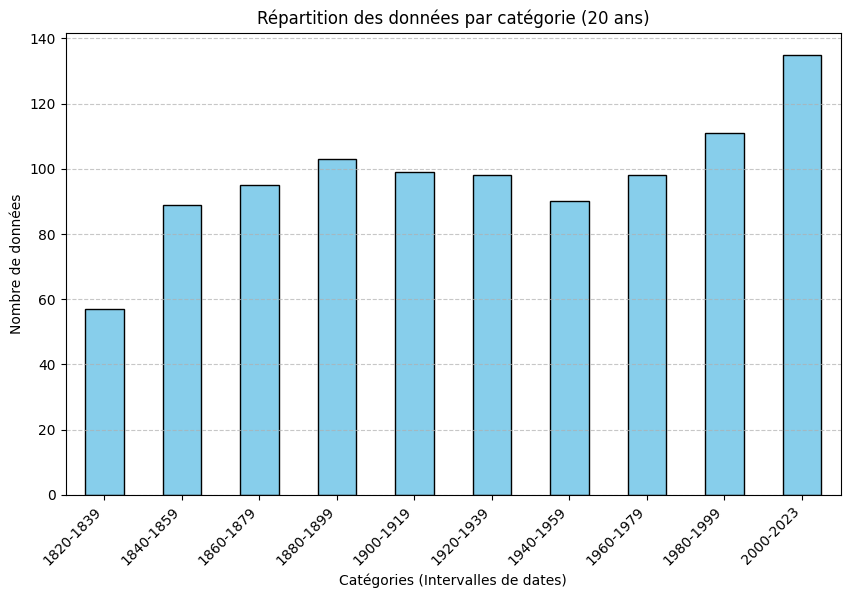

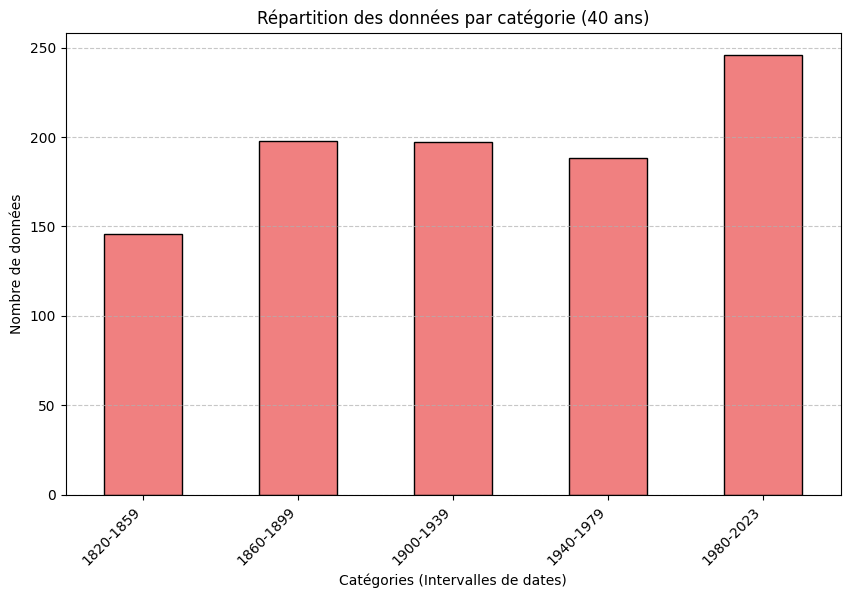

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Charger les données
file_path = "/content/drive/MyDrive/donnée.csv"
df = pd.read_csv(file_path, encoding='utf-8')

# Vérifier les colonnes présentes dans les données
print(df.columns)

# Vérifier les valeurs manquantes et remplir si nécessaire
df["Text"].fillna("", inplace=True)

# Fonction pour catégoriser les années
def categorize_years(df, interval):
    bins = list(range(1820, 2030, interval))
    bins[-1] = 2024
    labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins) - 1)]
    df["Category"] = pd.cut(df["Publication_Year"], bins=bins, labels=labels, right=False)
    return df

# Appliquer la catégorisation pour les intervalles de 20 ans et 40 ans
df_20 = categorize_years(df.copy(), 20)
df_40 = categorize_years(df.copy(), 40)

# Visualiser la répartition pour 20 ans
category_counts_20 = df_20["Category"].value_counts(sort=False)
plt.figure(figsize=(10, 6))
category_counts_20.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Répartition des données par catégorie (20 ans)")
plt.xlabel("Catégories (Intervalles de dates)")
plt.ylabel("Nombre de données")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualiser la répartition pour 40 ans
category_counts_40 = df_40["Category"].value_counts(sort=False)
plt.figure(figsize=(10, 6))
category_counts_40.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Répartition des données par catégorie (40 ans)")
plt.xlabel("Catégories (Intervalles de dates)")
plt.ylabel("Nombre de données")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# 4. Charger les modèles d'embeddings pré-entraînés
Ici, nous chargeons les modèles pré-entraînés pour Word2Vec, FastText et GloVe. Ces modèles permettent de convertir les textes en vecteurs numériques pour les étapes suivantes.

In [15]:
from gensim.models import KeyedVectors
import numpy as np

# Charger Word2Vec
word2vec_path = "/content/drive/MyDrive/frWiki_no_lem_no_postag_no_phrase_1000_cbow_cut100.bin"
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
print(f"Dimensions des vecteurs Word2Vec : {word2vec_model.vector_size}")

# Charger FastText
!wget -O cc.fr.300.vec.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
!gunzip cc.fr.300.vec.gz
fasttext_model = KeyedVectors.load_word2vec_format("cc.fr.300.vec", binary=False)
print(f"Dimensions des vecteurs FastText : {fasttext_model.vector_size}")

# Charger GloVe
!wget -O glove.6B.zip https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove_vectors

def load_glove_model(glove_file):
    model = {}
    with open(glove_file, "r", encoding="utf-8") as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=float)
            model[word] = embedding
    return model

glove_model = load_glove_model("glove_vectors/glove.6B.300d.txt")
print("Modèle GloVe chargé avec succès.")


Dimensions des vecteurs Word2Vec : 1000
--2025-01-21 18:33:07--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.51, 3.163.189.14, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287757366 (1.2G) [binary/octet-stream]
Saving to: ‘cc.fr.300.vec.gz’

cc.fr.300.vec.gz    100%[===================>]   1.20G  38.7MB/s    in 20s     

2025-01-21 18:33:26 (62.7 MB/s) - ‘cc.fr.300.vec.gz’ saved [1287757366/1287757366]

gzip: cc.fr.300.vec already exists; do you wish to overwrite (y or n)? N
	not overwritten
Dimensions des vecteurs FastText : 300
--2025-01-21 18:42:44--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting 

# 5. Extraire les embeddings pour chaque intervalle

Cette cellule applique les modèles Word2Vec, FastText et GloVe pour extraire les embeddings des textes pour les intervalles de 20 ans et 40 ans.(j'ai essayé avec 10 ET 30 aussi mais j'ai gardé les meileure résultats)

In [16]:
# Fonction pour extraire les embeddings
def extract_embeddings(texts, model, vector_size):
    embeddings = []
    for text in texts:
        tokens = text.split()
        vectors = [model[word] for word in tokens if word in model]
        if vectors:
            embeddings.append(np.mean(vectors, axis=0))
        else:
            embeddings.append(np.zeros(vector_size))  # Vecteur nul si aucun mot trouvé
    return embeddings

# Extraire les embeddings pour chaque modèle
for embedding_name, model, vector_size in [
    ("Word2Vec", word2vec_model, word2vec_model.vector_size),
    ("FastText", fasttext_model, fasttext_model.vector_size),
    ("GloVe", glove_model, 300)
]:
    print(f"Extraction des embeddings {embedding_name} pour 20 ans...")
    train_df_20[f"{embedding_name}_Embeddings"] = extract_embeddings(train_df_20["Text"], model, vector_size)
    test_df_20[f"{embedding_name}_Embeddings"] = extract_embeddings(test_df_20["Text"], model, vector_size)

    print(f"Extraction des embeddings {embedding_name} pour 40 ans...")
    train_df_40[f"{embedding_name}_Embeddings"] = extract_embeddings(train_df_40["Text"], model, vector_size)
    test_df_40[f"{embedding_name}_Embeddings"] = extract_embeddings(test_df_40["Text"], model, vector_size)


Extraction des embeddings Word2Vec pour 20 ans...
Extraction des embeddings Word2Vec pour 40 ans...
Extraction des embeddings FastText pour 20 ans...
Extraction des embeddings FastText pour 40 ans...
Extraction des embeddings GloVe pour 40 ans...


# 6. Entraîner et évaluer un modèle XGBoost pour la classification

Nous utilisons XGBoost pour entraîner un modèle de classification sur les embeddings extraits. Les performances sont évaluées à l'aide de courbes de pertes et d'un rapport de classification.

[0]	train-mlogloss:2.27588	test-mlogloss:2.29681
[1]	train-mlogloss:2.24794	test-mlogloss:2.29094
[2]	train-mlogloss:2.22059	test-mlogloss:2.28413
[3]	train-mlogloss:2.19453	test-mlogloss:2.27939
[4]	train-mlogloss:2.16813	test-mlogloss:2.27375
[5]	train-mlogloss:2.14279	test-mlogloss:2.26965
[6]	train-mlogloss:2.11711	test-mlogloss:2.26385
[7]	train-mlogloss:2.09183	test-mlogloss:2.25762
[8]	train-mlogloss:2.06778	test-mlogloss:2.25157
[9]	train-mlogloss:2.04351	test-mlogloss:2.24512
[10]	train-mlogloss:2.02014	test-mlogloss:2.24000
[11]	train-mlogloss:1.99716	test-mlogloss:2.23498
[12]	train-mlogloss:1.97426	test-mlogloss:2.22949
[13]	train-mlogloss:1.95185	test-mlogloss:2.22424
[14]	train-mlogloss:1.93009	test-mlogloss:2.21850
[15]	train-mlogloss:1.90877	test-mlogloss:2.21321
[16]	train-mlogloss:1.88793	test-mlogloss:2.20826
[17]	train-mlogloss:1.86769	test-mlogloss:2.20362
[18]	train-mlogloss:1.84717	test-mlogloss:2.19944
[19]	train-mlogloss:1.82731	test-mlogloss:2.19444
[20]	train

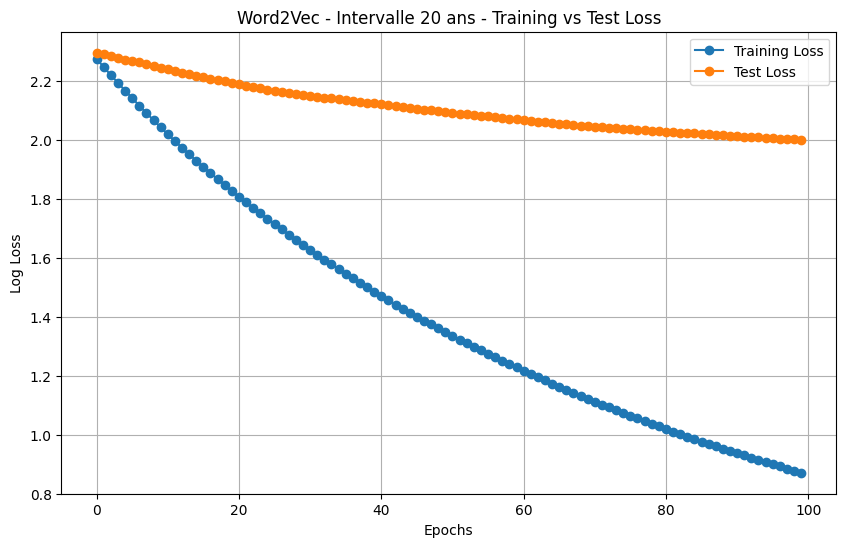


Rapport de classification pour Word2Vec - Intervalle 20 ans :
              precision    recall  f1-score   support

           0       0.23      0.33      0.27         9
           1       0.47      0.50      0.48        16
           2       0.32      0.41      0.36        17
           3       0.41      0.37      0.39        19
           4       0.35      0.26      0.30        23
           5       0.20      0.23      0.21        22
           6       0.12      0.10      0.11        21
           7       0.38      0.32      0.35        25
           8       0.14      0.19      0.16        16
           9       0.44      0.41      0.42        27

    accuracy                           0.31       195
   macro avg       0.31      0.31      0.31       195
weighted avg       0.32      0.31      0.31       195

[0]	train-mlogloss:2.27274	test-mlogloss:2.29410
[1]	train-mlogloss:2.24351	test-mlogloss:2.28399
[2]	train-mlogloss:2.21550	test-mlogloss:2.27680
[3]	train-mlogloss:2.18807	test

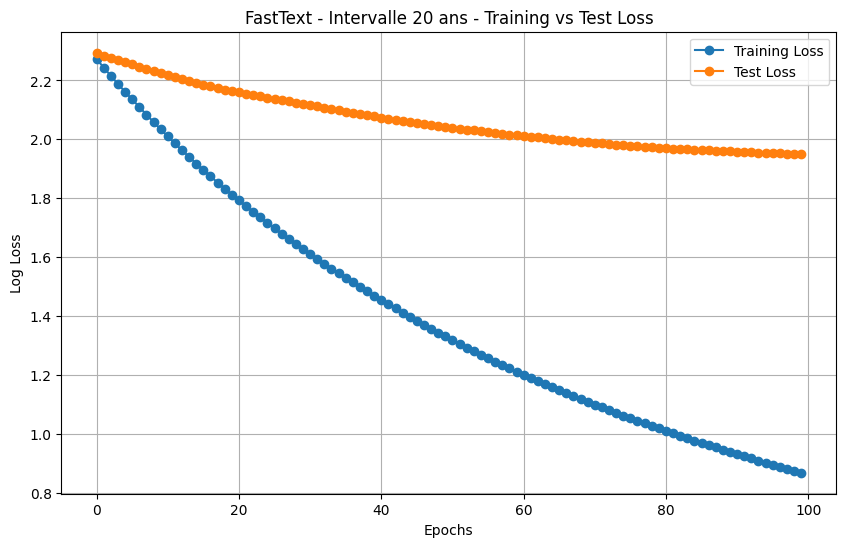


Rapport de classification pour FastText - Intervalle 20 ans :
              precision    recall  f1-score   support

           0       0.56      0.56      0.56         9
           1       0.35      0.50      0.41        16
           2       0.57      0.47      0.52        17
           3       0.25      0.26      0.26        19
           4       0.17      0.17      0.17        23
           5       0.20      0.18      0.19        22
           6       0.45      0.43      0.44        21
           7       0.25      0.12      0.16        25
           8       0.28      0.44      0.34        16
           9       0.55      0.59      0.57        27

    accuracy                           0.35       195
   macro avg       0.36      0.37      0.36       195
weighted avg       0.35      0.35      0.35       195

[0]	train-mlogloss:2.27268	test-mlogloss:2.29742
[1]	train-mlogloss:2.24391	test-mlogloss:2.29248
[2]	train-mlogloss:2.21631	test-mlogloss:2.28789
[3]	train-mlogloss:2.18990	test

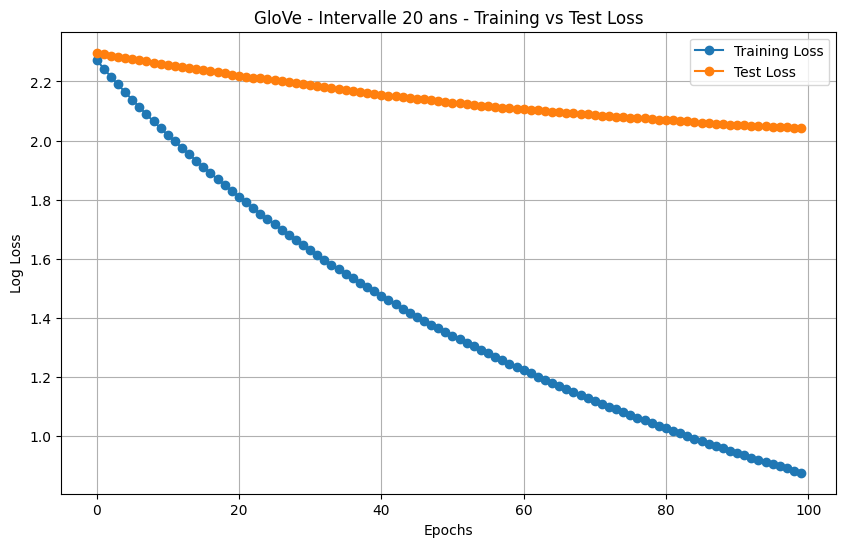


Rapport de classification pour GloVe - Intervalle 20 ans :
              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.11      0.12      0.11        16
           2       0.28      0.29      0.29        17
           3       0.20      0.26      0.23        19
           4       0.37      0.30      0.33        23
           5       0.12      0.09      0.10        22
           6       0.27      0.29      0.28        21
           7       0.28      0.20      0.23        25
           8       0.35      0.50      0.41        16
           9       0.60      0.56      0.58        27

    accuracy                           0.30       195
   macro avg       0.30      0.31      0.30       195
weighted avg       0.31      0.30      0.30       195

[0]	train-mlogloss:1.59304	test-mlogloss:1.60377
[1]	train-mlogloss:1.57634	test-mlogloss:1.59815
[2]	train-mlogloss:1.56023	test-mlogloss:1.59271
[3]	train-mlogloss:1.54414	test-ml

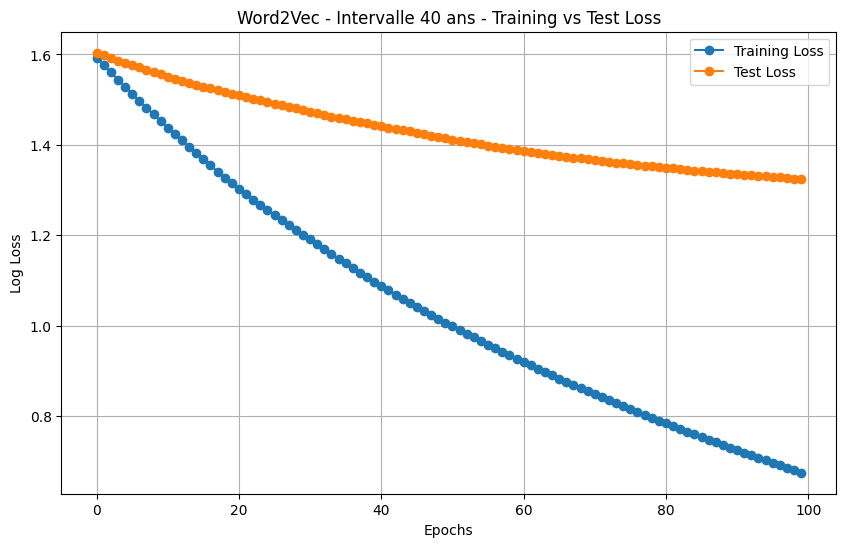


Rapport de classification pour Word2Vec - Intervalle 40 ans :
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        25
           1       0.47      0.56      0.51        36
           2       0.41      0.27      0.32        45
           3       0.54      0.41      0.47        46
           4       0.53      0.72      0.61        43

    accuracy                           0.51       195
   macro avg       0.50      0.53      0.51       195
weighted avg       0.50      0.51      0.49       195

[0]	train-mlogloss:1.59178	test-mlogloss:1.60283
[1]	train-mlogloss:1.57456	test-mlogloss:1.59659
[2]	train-mlogloss:1.55761	test-mlogloss:1.58997
[3]	train-mlogloss:1.54103	test-mlogloss:1.58425
[4]	train-mlogloss:1.52449	test-mlogloss:1.57741
[5]	train-mlogloss:1.50838	test-mlogloss:1.57161
[6]	train-mlogloss:1.49259	test-mlogloss:1.56575
[7]	train-mlogloss:1.47726	test-mlogloss:1.56001
[8]	train-mlogloss:1.46207	test-mlogloss:1.55463
[9]	tra

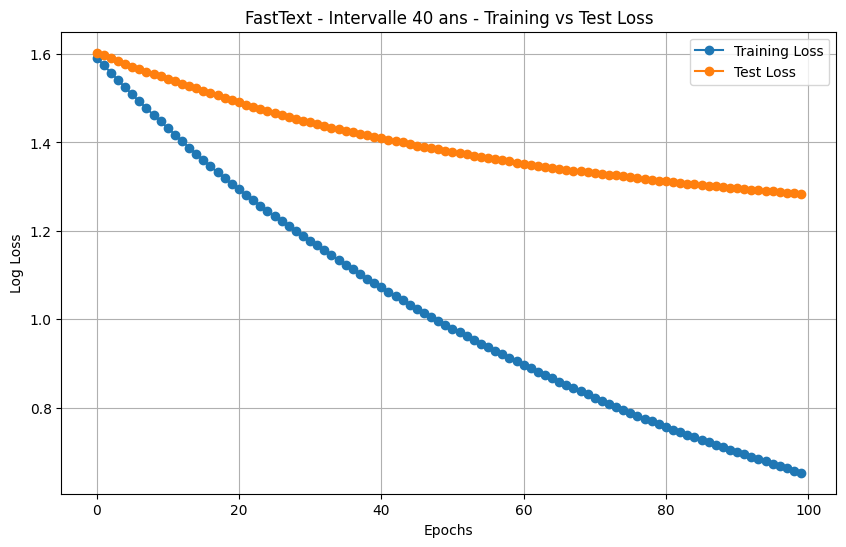


Rapport de classification pour FastText - Intervalle 40 ans :
              precision    recall  f1-score   support

           0       0.44      0.60      0.51        25
           1       0.42      0.44      0.43        36
           2       0.36      0.31      0.33        45
           3       0.48      0.33      0.39        46
           4       0.64      0.79      0.71        43

    accuracy                           0.48       195
   macro avg       0.47      0.49      0.47       195
weighted avg       0.47      0.48      0.47       195

[0]	train-mlogloss:1.59339	test-mlogloss:1.60477
[1]	train-mlogloss:1.57769	test-mlogloss:1.59961
[2]	train-mlogloss:1.56238	test-mlogloss:1.59477
[3]	train-mlogloss:1.54683	test-mlogloss:1.58988
[4]	train-mlogloss:1.53121	test-mlogloss:1.58493
[5]	train-mlogloss:1.51581	test-mlogloss:1.57949
[6]	train-mlogloss:1.50085	test-mlogloss:1.57439
[7]	train-mlogloss:1.48638	test-mlogloss:1.56932
[8]	train-mlogloss:1.47182	test-mlogloss:1.56479
[9]	tra

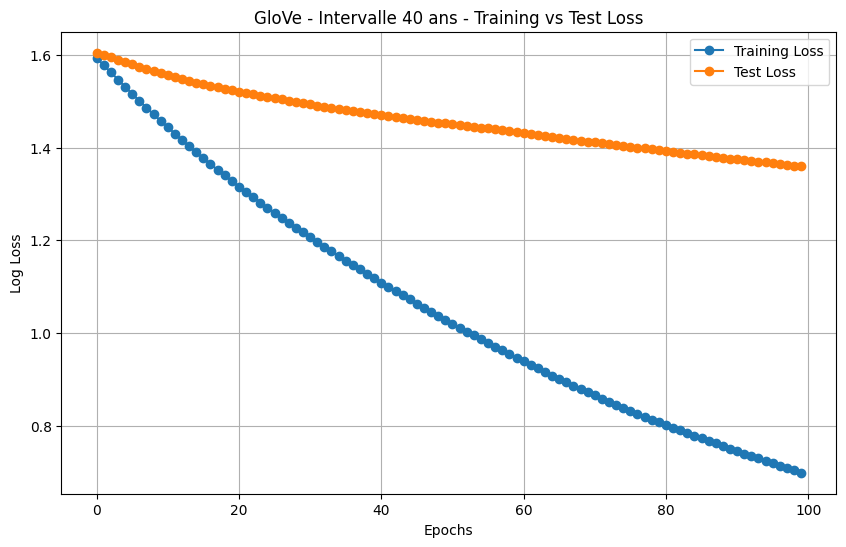


Rapport de classification pour GloVe - Intervalle 40 ans :
              precision    recall  f1-score   support

           0       0.38      0.32      0.35        25
           1       0.43      0.61      0.51        36
           2       0.23      0.16      0.18        45
           3       0.50      0.35      0.41        46
           4       0.57      0.79      0.66        43

    accuracy                           0.45       195
   macro avg       0.42      0.45      0.42       195
weighted avg       0.42      0.45      0.42       195



In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Fonction pour entraîner et évaluer XGBoost
def train_and_evaluate_xgboost(train_df, test_df, embedding_name, interval):
    X_train = np.stack(train_df[f"{embedding_name}_Embeddings"])
    X_test = np.stack(test_df[f"{embedding_name}_Embeddings"])
    y_train = train_df["labels"]
    y_test = test_df["labels"]

    # Convertir les données en DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Définir les paramètres
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_train)),
        'learning_rate': 0.01,
        'max_depth': 6,
        'lambda': 0.01,
        'eval_metric': 'mlogloss',
        'seed': 42
    }

    # Entraîner le modèle
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=3,
        evals_result=evals_result,
        verbose_eval=True
    )

    # Courbes de pertes
    train_loss = evals_result['train']['mlogloss']
    test_loss = evals_result['test']['mlogloss']
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', marker='o')
    plt.plot(test_loss, label='Test Loss', marker='o')
    plt.title(f"{embedding_name} - Intervalle {interval} ans - Training vs Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Prédictions et rapport de classification
    y_pred = np.argmax(model.predict(dtest), axis=1)
    print(f"\nRapport de classification pour {embedding_name} - Intervalle {interval} ans :")
    print(classification_report(y_test, y_pred))

# Appliquer pour les intervalles de 20 ans et 40 ans
for interval, train_df, test_df in [
    (20, train_df_20, test_df_20),
    (40, train_df_40, test_df_40)
]:
    for embedding_name in ["Word2Vec", "FastText", "GloVe"]:
        train_and_evaluate_xgboost(train_df, test_df, embedding_name, interval)


# 7. Entraîner et évaluer un modèle Random Forest pour la classification

Dans cette étape, nous utilisons Random Forest pour entraîner et évaluer un modèle de classification. Nous visualisons également les courbes de pertes en fonction du nombre d'arbres dans la forêt.


Rapport de classification pour Word2Vec :
              precision    recall  f1-score   support

   1820-1859       0.62      0.72      0.67        25
   1860-1899       0.60      0.58      0.59        36
   1900-1939       0.44      0.33      0.38        45
   1940-1979       0.48      0.43      0.45        46
   1980-2023       0.58      0.74      0.65        43

    accuracy                           0.54       195
   macro avg       0.54      0.56      0.55       195
weighted avg       0.53      0.54      0.53       195



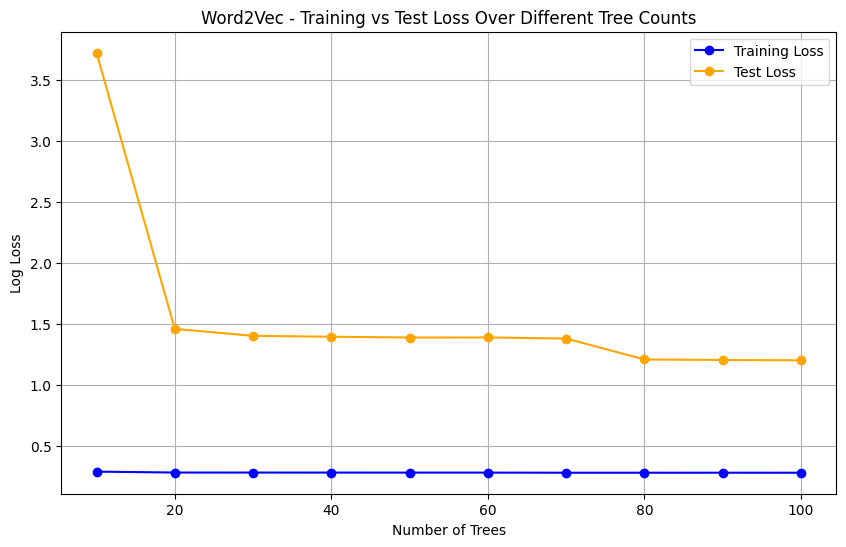


Rapport de classification pour FastText :
              precision    recall  f1-score   support

   1820-1859       0.60      0.60      0.60        25
   1860-1899       0.46      0.61      0.52        36
   1900-1939       0.41      0.27      0.32        45
   1940-1979       0.55      0.39      0.46        46
   1980-2023       0.63      0.88      0.74        43

    accuracy                           0.54       195
   macro avg       0.53      0.55      0.53       195
weighted avg       0.53      0.54      0.52       195



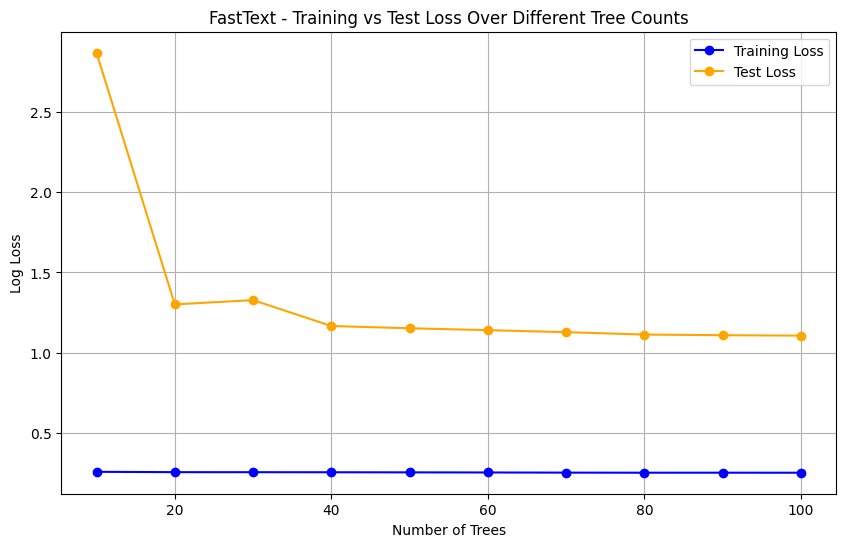


Rapport de classification pour GloVe :
              precision    recall  f1-score   support

   1820-1859       0.58      0.44      0.50        25
   1860-1899       0.44      0.58      0.50        36
   1900-1939       0.32      0.31      0.31        45
   1940-1979       0.64      0.30      0.41        46
   1980-2023       0.55      0.79      0.65        43

    accuracy                           0.48       195
   macro avg       0.50      0.49      0.47       195
weighted avg       0.50      0.48      0.47       195



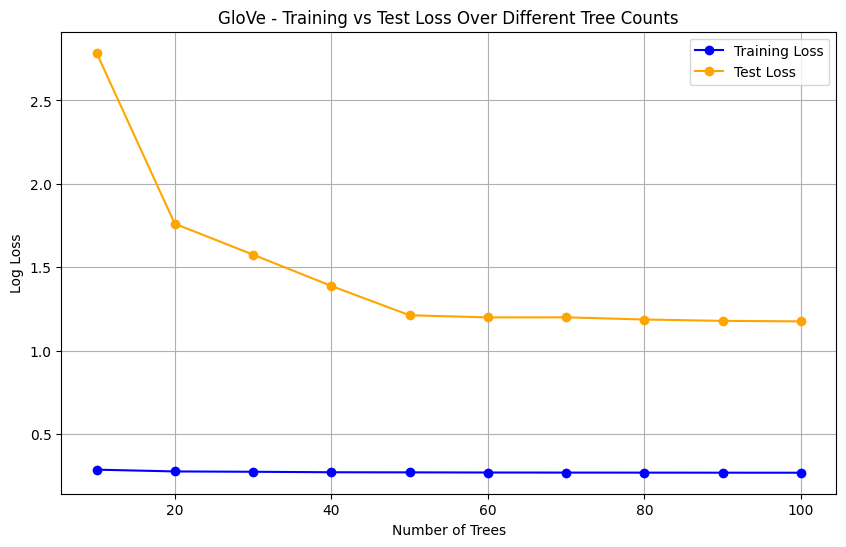

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
import matplotlib.pyplot as plt
import numpy as np

# Fonction d'entraînement et d'évaluation avec affichage des courbes de pertes
def train_and_evaluate_with_curves_random_forest(X_train, X_test, y_train, y_test, embedding_name):
    # Configurer le modèle Random Forest
    model = RandomForestClassifier(
        n_estimators=100,  # Nombre d'arbres
        max_depth=None,    # Profondeur maximale des arbres
        random_state=42,   # Assurer la reproductibilité
        n_jobs=-1          # Utilisation de tous les cœurs pour accélérer
    )

    # Suivi des pertes à différents stades
    train_losses = []
    test_losses = []
    steps = np.linspace(10, 100, 10, dtype=int)  # Intervalles de nombre d'arbres (10, 20, ..., 100)

    for n_estimators in steps:
        # Reconfigurer le modèle pour chaque étape
        model.set_params(n_estimators=n_estimators)

        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Prédictions des probabilités
        y_train_proba = model.predict_proba(X_train)
        y_test_proba = model.predict_proba(X_test)

        # Calcul des pertes (log loss)
        train_loss = log_loss(y_train, y_train_proba)
        test_loss = log_loss(y_test, y_test_proba)

        # Stocker les pertes
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Prédictions pour le rapport de classification final
    model.fit(X_train, y_train)  # Entraînement final avec tous les arbres
    y_pred = model.predict(X_test)

    # Rapport de classification
    print(f"\nRapport de classification pour {embedding_name} :")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Courbes des pertes
    plt.figure(figsize=(10, 6))
    plt.plot(steps, train_losses, label='Training Loss', marker='o', color='blue')
    plt.plot(steps, test_losses, label='Test Loss', marker='o', color='orange')
    plt.title(f"{embedding_name} - Training vs Test Loss Over Different Tree Counts")
    plt.xlabel("Number of Trees")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Appliquer la fonction pour chaque embedding
for embedding_name in ["Word2Vec", "FastText", "GloVe"]:
    # Préparer les données
    X_train = np.stack(train_df[f"{embedding_name}_Embeddings"])
    X_test = np.stack(test_df[f"{embedding_name}_Embeddings"])
    y_train = train_df["labels"]
    y_test = test_df["labels"]

    # Entraîner et évaluer
    train_and_evaluate_with_curves_random_forest(X_train, X_test, y_train, y_test, embedding_name)


# 8. Régression pour prédire les années exactes
Dans cette cellule, nous utilisons XGBoost en mode régression pour prédire directement les années exactes de publication des textes, et évaluons les erreurs (MAE, RMSE).

In [19]:
# Définir les features et le label pour la régression
X_train = np.stack(train_df["Word2Vec_Embeddings"])
y_train = train_df["Publication_Year"]  # Année exacte comme variable cible
X_test = np.stack(test_df["Word2Vec_Embeddings"])
y_test = test_df["Publication_Year"]


In [20]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Configurer XGBoost pour la régression
model = XGBRegressor(
    objective="reg:squarederror",  # Régression
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entraîner le modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluer les performances
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 24.17
Root Mean Squared Error (RMSE): 32.26


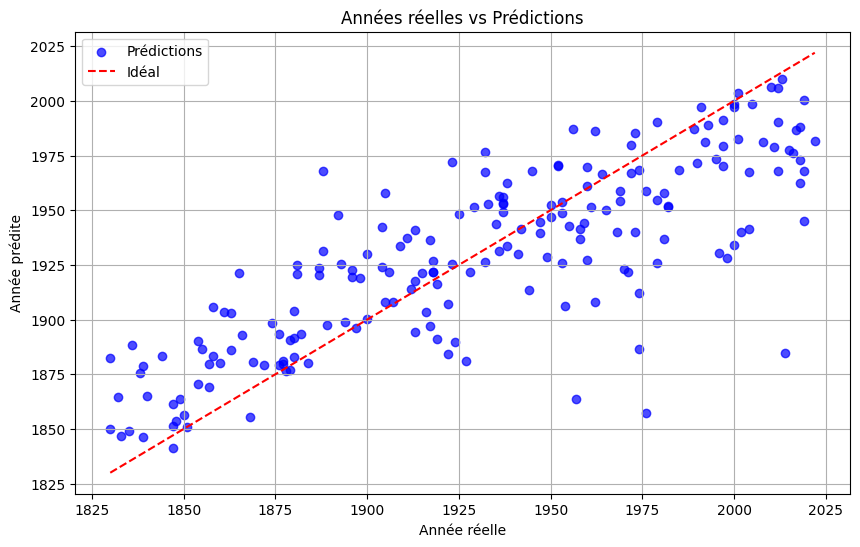

In [21]:
import matplotlib.pyplot as plt

# Tracer les années réelles vs prédites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label="Prédictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Idéal")
plt.title("Années réelles vs Prédictions")
plt.xlabel("Année réelle")
plt.ylabel("Année prédite")
plt.legend()
plt.grid()

Mean Absolute Error (MAE): 24.17
Root Mean Squared Error (RMSE): 32.26
Pourcentage de prédictions correctes dans ±20 ans : 50.26%


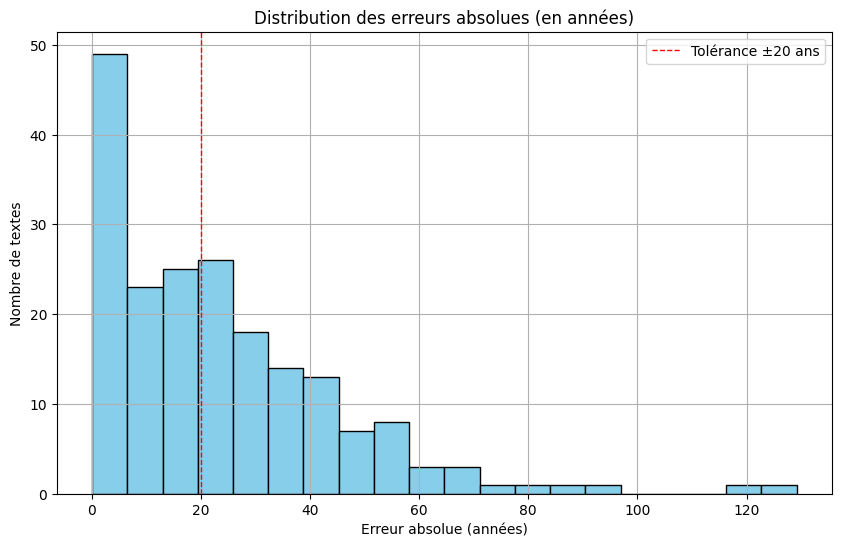

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcul des métriques de base
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calcul des erreurs absolues
absolute_errors = abs(y_test - y_pred)

# Vérifier les prédictions dans l'intervalle ±20 ans
tolerance = 20
within_tolerance = (absolute_errors <= tolerance)

# Calcul du pourcentage de prédictions correctes
accuracy_with_tolerance = np.mean(within_tolerance) * 100
print(f"Pourcentage de prédictions correctes dans ±{tolerance} ans : {accuracy_with_tolerance:.2f}%")

# Visualiser les erreurs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(absolute_errors, bins=20, color='skyblue', edgecolor='black')
plt.axvline(tolerance, color='red', linestyle='dashed', linewidth=1, label=f'Tolérance ±{tolerance} ans')
plt.title("Distribution des erreurs absolues (en années)")
plt.xlabel("Erreur absolue (années)")
plt.ylabel("Nombre de textes")
plt.legend()
plt.grid()
plt.show()
